# German Credit Risk Classification

Using pre-labeled data from the following Kaggle link:

https://www.kaggle.com/uciml/german-credit

This is a well known dataset for a classification of consumers into good and bad credit risks. As the dataset comes pre-labelled, a supervised approach is taken and variety of methods are used here to demonstrate the capabilities of different supervised classification algorithms.

If the dataset came unlabeled, an unsupervised approach here would be warranted. Clustering algorithms such as K-means or DBScan would be viable options, but likely with similar consumer credit risk data with incomplete data and lack of history for certain consumers, a semi-supervised approach may also be a viable option.

In [40]:
# MISCELLANEOUS IMPORTS
import pandas as pd
import patsy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

# MODELLING AND METRICS IMPORTS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron, RidgeClassifier
from xgboost import XGBClassifier

In [2]:
# SET SEABORN STYLE
sns.set(context='paper', style='white', palette='bone', font='sansserif', font_scale=1.5, color_codes=False, rc=None)

# SET FONT DICTIONARY
font = {'family': 'sansserif',
        'color':  'black',
        'weight': 'normal',
        'variant': 'small-caps',
        'size': 14
        }

# Data Loading, Exploration and Cleaning

The dataset contains information on demographic data of the consumers with credit, their financial status indicators and information pertaining to their credit as well. A total of 9 features are given as potential predictors for their credit and we will be using all (after conversion) to predict whether a particular consumer is classified as a good or bad creditor.

In [66]:
# HEAD OF DATA FRAME
data_raw = pd.read_csv('german_credit_risk.csv')
data_raw.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Class  
0           1169         6             radio/TV      1  
1           5951        48             radio/TV      2  
2           2096        12            education      1  
3           7882        42  furniture/equipment      1  
4           4870        24                  car      2

In [68]:
# CHECK FOR NULL VALUES
data_raw.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Class                 0
dtype: int64

The data needs to be cleaned and missing values need to be imputed. Features containing string values such as 'male' and 'female' or 'free', 'rent' and 'own' are approriately encoded as binary variables. A one hot encoder is used below to build a matrix that can be plugged into classification algorithms easily.

Patsy is an alternative to using a one hot encoder to build a feature dataframe with column names specified, if insight into the weights of particular features are more relevant than the prediction itself.

In [3]:
# DATA CLEANING
data = data_raw.ix[:,1:10]
label = data_raw.ix[:,10]
datan = data
datan = datan.replace(['male','female'],[0,1])
datan = datan.replace(['free','rent','own'],[0,1,2])
datan = datan.replace(['little','moderate','quite rich','rich'],[1,2,3,4])
datan = datan.replace(['radio/TV','repairs','domestic appliances','vacation/others','furniture/equipment','car','education','business'],[1,2,3,4,5,6,7,8])
datan = datan.fillna(0)
enc = OneHotEncoder(categorical_features = [1,2,3,4,5,8],sparse = False)
enc.fit(datan)
dataprocessed = enc.transform(datan)

In [71]:
# OVERVIEW OF THE DATA
datan.describe()

Age          Sex          Job      Housing  Saving accounts  \
count  1000.000000  1000.000000  1000.000000  1000.000000      1000.000000   
mean     35.546000     0.310000     1.904000     1.605000         1.190000   
std      11.375469     0.462725     0.653614     0.674856         0.966869   
min      19.000000     0.000000     0.000000     0.000000         0.000000   
25%      27.000000     0.000000     2.000000     1.000000         1.000000   
50%      33.000000     0.000000     2.000000     2.000000         1.000000   
75%      42.000000     1.000000     2.000000     2.000000         1.000000   
max      75.000000     1.000000     3.000000     2.000000         4.000000   

       Checking account  Credit amount     Duration      Purpose  
count        1000.00000    1000.000000  1000.000000  1000.000000  
mean            1.06400    3271.258000    20.903000     4.524000  
std             1.10776    2822.736876    12.058814     2.442005  
min             0.00000     250.000000     4.000000     1.000000  
25%             0.00000    1365.500000    12.000000     1.000000  
50%             1.00000    2319.500000    18.000000     5.000000  
75%             2.00000    3972.250000    24.000000     6.000000  
max             4.00000   18424.000000    72.000000     8.000000

While we will be using a cross validated grid search and the dataset is relatively small, it is worthwhile to split the data regardless and use a hold-out test split to test the accuracy of the grid searched predictor on 'real world' data, a test size of 20% will be used.

In [52]:
# TRAIN AND TEST SPLIT WITH TEST SIZE OF 20%
data_train,data_test,label_train,label_test = train_test_split(dataprocessed,label,test_size = 0.2)

# Modelling with default parameters on multiple classifier algorithms

- **K Neighbors** - Uses a preset number of neighbors to classify i.e. if n = 3 the three nearest neighbors to a point are of a single class it will be classified as that particular class.
- **Logistic Regression** - Bread and butter of linear classification algorithms. Efficient and robust to noise.
- **Decision Trees** - Uses nodes (and child nodes) and questions regarding each feature to build an optimal decision tree to classify.
- **Support Vector Machines** - Builds a maximum margin between two boundaries built using support vectors, the maximum margin is only affected by the support vectors and new data not falling on boundary lines do not affect the margin. Also good for high dimensional data as it can use a kernel trick to build a hyperplane for class separation.
- **Random Forests** - Ensemble learning method bagging decision tree classifers to classify on the modal class. One of the better working classification algorithms but also prone to overfitting on training data.
- **Extra Trees** - Extra trees are similar to random forests except splits are selected at random rather than using a criterion.
- **Stochastic Gradient Descent** - Linear classifier using stepwise optimization of loss function given a subset of the training data.
- **Perceptron** - A very basic neural network resembling a stochastic gradient descent classifier using heaviside step function.
- **Passive Aggressive** - Linear classifier that adjusts the model according to whether a classification is correct or not, in passive, if it is a correct classification it will keep the model, in aggressive, if it is an incorrect classification, the model is updated to adjust to this misclassified example. Also has a regularization parameter.
- **Ridge Classifier** - Another linear classifier that uses ridge regularization on a feature set, useful when you want to use all features.
- **Bernoulli Naive Bayes** - Naive Bayes is a simple probabilistic classifier based on Bayes theorem which assumes (naively) independence between features.

To start we will be throwing a multitude of classifiers on the data to see what performs best with the default parameters setting for the classifiers and also use a principal component analysis on our feature set to reduce the dimensionality of the data, the grid search will find the optimal number of components for each particular algorithm. 

Note: Standardization is necessary to ensure our features are all on the same scale.

In [50]:
# SET PARAMETER SPACE FOR GRID SEARCH ON PCA COMPONENTS
parameters = {
'pca__n_components': [2, 4, 8, 10, 20, 25, 29]
}

In [43]:
# LIST OF BINARY CLASSIFIERS
models = [KNeighborsClassifier(),
          LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(),
          RandomForestClassifier(),
          ExtraTreesClassifier(),
          SGDClassifier(),
          Perceptron(),
          PassiveAggressiveClassifier(),
          RidgeClassifier(),
          BernoulliNB(),
          ]

In [44]:
# USED TO PLOT A CONFUSION MATRIX TO CHECK HOW THE CLASSIFICATION MODEL WORKS ON THE TEST SET
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.bone):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict=font)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white",
                fontdict=font)
    plt.ylabel('True label', fontdict=font, fontsize=10)
    plt.xlabel('Predicted label', fontdict=font, fontsize=10)
    plt.show()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished


Model KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Grid Search Best Score: 0.685
Grid Search Best Params: {'pca__n_components': 20}
Classification Report:              precision    recall  f1-score   support

          1       0.77      0.89      0.82       140
          2       0.58      0.37      0.45        60

avg / total       0.71      0.73      0.71       200

Accuracy on Test Data: 0.730


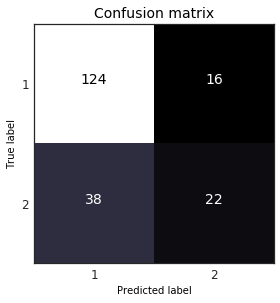

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished


Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Grid Search Best Score: 0.73125
Grid Search Best Params: {'pca__n_components': 20}
Classification Report:              precision    recall  f1-score   support

          1       0.76      0.86      0.81       140
          2       0.54      0.37      0.44        60

avg / total       0.69      0.71      0.70       200

Accuracy on Test Data: 0.715


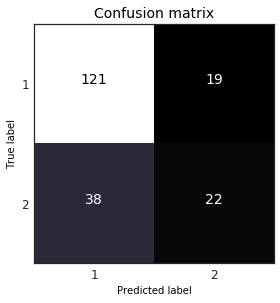

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.7s finished


Model DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Grid Search Best Score: 0.67125
Grid Search Best Params: {'pca__n_components': 25}
Classification Report:              precision    recall  f1-score   support

          1       0.77      0.79      0.78       140
          2       0.47      0.45      0.46        60

avg / total       0.68      0.69      0.68       200

Accuracy on Test Data: 0.685


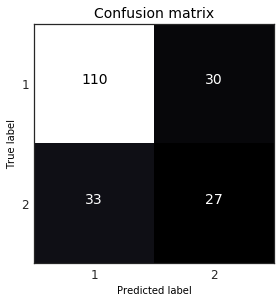

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.4s finished


Model SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Grid Search Best Score: 0.73625
Grid Search Best Params: {'pca__n_components': 29}
Classification Report:              precision    recall  f1-score   support

          1       0.75      0.91      0.82       140
          2       0.59      0.28      0.38        60

avg / total       0.70      0.72      0.69       200

Accuracy on Test Data: 0.725


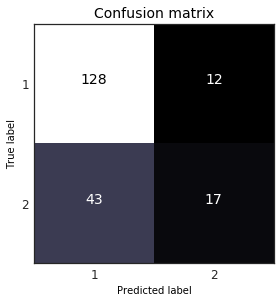

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.5s finished


Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Grid Search Best Score: 0.72625
Grid Search Best Params: {'pca__n_components': 25}
Classification Report:              precision    recall  f1-score   support

          1       0.72      0.87      0.79       140
          2       0.40      0.20      0.27        60

avg / total       0.62      0.67      0.63       200

Accuracy on Test Data: 0.670


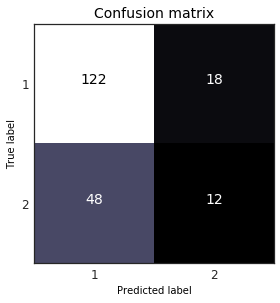

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.0s finished


Model ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Grid Search Best Score: 0.715
Grid Search Best Params: {'pca__n_components': 25}
Classification Report:              precision    recall  f1-score   support

          1       0.75      0.88      0.81       140
          2       0.53      0.32      0.40        60

avg / total       0.68      0.71      0.69       200

Accuracy on Test Data: 0.710


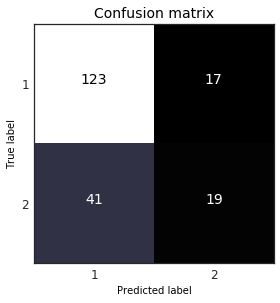

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished


Model SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Grid Search Best Score: 0.69
Grid Search Best Params: {'pca__n_components': 25}
Classification Report:              precision    recall  f1-score   support

          1       0.74      0.74      0.74       140
          2       0.40      0.40      0.40        60

avg / total       0.64      0.64      0.64       200

Accuracy on Test Data: 0.640


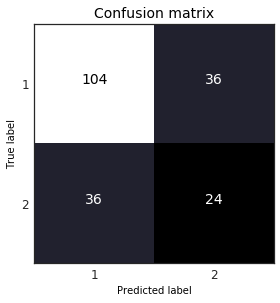

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished


Model Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
Grid Search Best Score: 0.63625
Grid Search Best Params: {'pca__n_components': 4}
Classification Report:              precision    recall  f1-score   support

          1       0.70      0.99      0.82       140
          2       0.00      0.00      0.00        60

avg / total       0.49      0.69      0.57       200

Accuracy on Test Data: 0.695


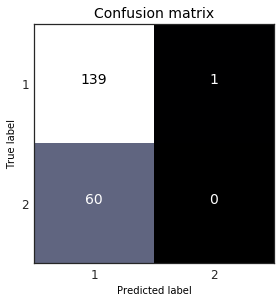

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished


Model PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=5, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
Grid Search Best Score: 0.6625
Grid Search Best Params: {'pca__n_components': 10}
Classification Report:              precision    recall  f1-score   support

          1       0.73      0.69      0.71       140
          2       0.36      0.42      0.39        60

avg / total       0.62      0.60      0.61       200

Accuracy on Test Data: 0.605


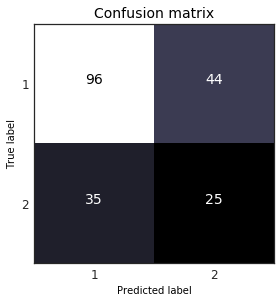

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished


Model RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
Grid Search Best Score: 0.735
Grid Search Best Params: {'pca__n_components': 20}
Classification Report:              precision    recall  f1-score   support

          1       0.76      0.89      0.82       140
          2       0.58      0.35      0.44        60

avg / total       0.71      0.73      0.71       200

Accuracy on Test Data: 0.730


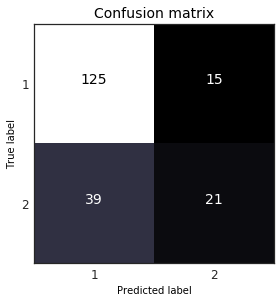

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished


Model BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Grid Search Best Score: 0.7175
Grid Search Best Params: {'pca__n_components': 8}
Classification Report:              precision    recall  f1-score   support

          1       0.74      0.94      0.83       140
          2       0.64      0.23      0.34        60

avg / total       0.71      0.73      0.68       200

Accuracy on Test Data: 0.730


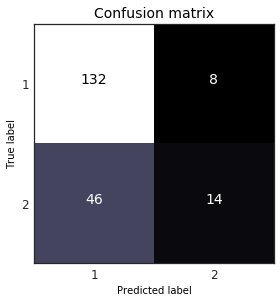

In [51]:
for model in models:
    pipeline = Pipeline([
        ('ss', StandardScaler()),
        ('pca', PCA(random_state=42)),
        ('clf', model), 
    ])
    grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=5)
    grid_search.fit(data_train, label_train)
    print "Model", model
    print "Grid Search Best Score:", grid_search.best_score_
    print "Grid Search Best Params:", grid_search.best_params_
    
    predictions = grid_search.best_estimator_.predict(data_test)
    print "Classification Report:", classification_report(label_test, predictions)
    print 'Accuracy on Test Data: {0:.3f}'.format(accuracy_score(label_test, predictions))  

    cnf_matrix = confusion_matrix(label_test, predictions)
    plot_confusion_matrix(cnf_matrix, classes=grid_search.best_estimator_.classes_)

The grid search revealed SVC, Logistic Regression and Random Forest to be the best classifiers based on the grid searched best score on the training data. The number of principal components ranged from 4 to 25.

Choosing the three best performing models, let's see if we can improve these models scores by tuning the hyperparameters of each of these classification algorithms along with PCA components to see if we can improve the score.

# Gridsearching Random Forest w/ PCA

In [54]:
rf = RandomForestClassifier()

In [55]:
rf_parameters = {
           "clf__n_estimators"      : [100, 300],
           # NUMBER OF TREES IN THE FOREST
    
           "clf__criterion"         : ["gini", "entropy"],
           # METRICS ON WHICH TO SPLIT THE DATA:
           # ENTROPY: MEASUREMENT OF INFORMATION GAIN
           # GINI: PROBABILITY OF CLASSIFYING RANDOM SAMPLE CORRECTLY
    
           "clf__max_depth"         : [10, 20],
           # MAX NO. OF FEATURES TO CONSIDER WHEN LOOKING FOR BEST SPLIT 
    
           "clf__min_samples_split" : [2, 4],
           # MINIMUM NUMBER OF SAMPLES REQUIRED TO SPLIT A NODE
    
           "clf__bootstrap"         : [True, False],
           # WHETHER TO USE BOOTSTRAP SAMPLES OR NOT (FORM OF RESAMPLING)
    
           "pca__n_components"      : [2, 8, 10, 20, 25, 29]
           # NO OF PRINCIPAL COMPONENTS
}

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed: 14.0min finished


Ranfom Forest Gridsearch
Grid Search Best Score: 0.73375
Grid Search Best Params: {'clf__n_estimators': 100, 'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_depth': 20, 'pca__n_components': 8, 'clf__min_samples_split': 4}
Grid Search Best Estimator: Pipeline(steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=8, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_de...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
Classification Report:              precision    recall  f1-score   support

          1       0.73      0.85      0.79       140
          2       0.45      0.28      0.35        60

avg / total       0.65      0.68      0.66       200

Accuracy: 0.680


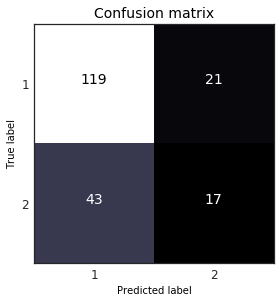

In [251]:
pipeline = Pipeline([
        ('ss', StandardScaler()),
        ('pca', PCA(random_state=42)),
        ('clf', rf)
    ])
grid_search = GridSearchCV(pipeline, rf_parameters, verbose=1, cv=5)
grid_search.fit(data_train, label_train)
print "Ranfom Forest Gridsearch"
print "Grid Search Best Score:", grid_search.best_score_
print "Grid Search Best Params:", grid_search.best_params_
print "Grid Search Best Estimator:", grid_search.best_estimator_
    
predictions = grid_search.best_estimator_.predict(data_test)
print "Classification Report:", classification_report(label_test, predictions)
print 'Accuracy: {0:.3f}'.format(accuracy_score(label_test, predictions))  

    
cnf_matrix = confusion_matrix(label_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=grid_search.best_estimator_.classes_)

The best score generated by the model is 0.73375 compared to 0.72625 on the non hyper parameter tuned Random Forest. This minor improvement is good but once again the Random Forest underperforms when measuring the accuracy on the test hold out data with an accuracy of only 0.68, this means that there is overfitting to the training data.

# Gridsearching Logistic Regression w/ PCA

In [30]:
lr = LogisticRegression()

In [31]:
lr_parameters = {
           "clf__penalty"      : ['l2'],
           # PENALTY SET WITH RIDGE DUE TO OTHER SOLVERS ONLY USING RIDGE
    
           "clf__C"            : [0.001, 0.01, 0.1, 1, 100],
           # INVERSE OF REGULARIZATION STRENGTH
    
           "clf__solver"       : ['liblinear', 'sag'],
           # ALGORITHM USED IN OPTIMIZATION PROBLEM
    
           "clf__tol"          : [0.0001, 0.001, 0.01],
           # TOLERANCE FOR STOPPING CRITERIA
    
           "pca__n_components" : [2, 8, 10, 20, 25, 29]
           # NO. OF PRINCIPAL COMPONENTS
}

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    9.2s finished
//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sansserif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Logistic Regression Gridsearch
Grid Search Best Score: 0.7325
Grid Search Best Params: {'clf__tol': 0.0001, 'clf__penalty': 'l2', 'clf__C': 0.01, 'clf__solver': 'liblinear', 'pca__n_components': 10}
Grid Search Best Estimator: Pipeline(steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Classification Report:              precision    recall  f1-score   support

          1       0.78      0.86      0.82       140
          2       0.57      0.42      0.48        60

avg / total       0.71      0.73      0.72       200

Accuracy: 0.730


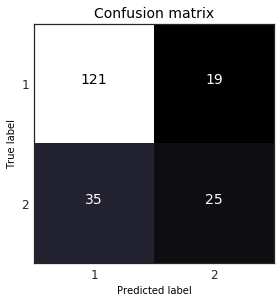

In [32]:
pipeline = Pipeline([
        ('ss', StandardScaler()),
        ('pca', PCA(random_state=42)),
        ('clf', lr)
    ])
grid_search = GridSearchCV(pipeline, lr_parameters, verbose=1, cv=5)
grid_search.fit(data_train, label_train)
print "Logistic Regression Gridsearch"
print "Grid Search Best Score:", grid_search.best_score_
print "Grid Search Best Params:", grid_search.best_params_
print "Grid Search Best Estimator:", grid_search.best_estimator_
    
predictions = grid_search.best_estimator_.predict(data_test)
print "Classification Report:", classification_report(label_test, predictions)
print 'Accuracy: {0:.3f}'.format(accuracy_score(label_test, predictions))  
    
cnf_matrix = confusion_matrix(label_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=grid_search.best_estimator_.classes_)

The score improved very slightly on logistic regression from 0.7315 to 0.7325 on the grid search but however performs a bit better on classification accuracy on the test hold out data, at 0.73 rather than 0.715. The translation from the training data to test data actually improves which shows it is likely more reliable with new data than the Random Forest.

# Gridsearching Support Vector Classifier w/ PCA

In [56]:
svc = SVC(random_state=42)

In [64]:
svc_parameters = {
           "clf__kernel"      : ['rbf', 'linear'],
           # KERNEL TYPE TO BE USED
    
           "clf__C"           : [0.1, 1, 10, 100],
           # PENALTY PARAMETER FOR ERROR TERM
    
           "clf__gamma"       : [0.001, 0.01, 0.1, 1],
           # KERNAL COEFFICIENT (SMOOTHING)
    
           "pca__n_components": [8, 10, 20, 25, 29]
           # NO. OF PRINCIPAL COMPONENTS
}

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:  8.7min finished


Logistic Regression Gridsearch
Grid Search Best Score: 0.73125
Grid Search Best Params: {'clf__gamma': 0.001, 'clf__degree': 1, 'pca__n_components': 20, 'clf__C': 100, 'clf__kernel': 'rbf'}
Grid Search Best Estimator: Pipeline(steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
Classification Report:              precision    recall  f1-score   support

          1       0.79      0.85      0.82       148
          2       0.45      0.35      0.39        52

avg / total       0.70      0.72      0.71       200

Accuracy: 0.720


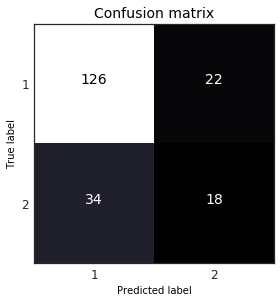

In [65]:
pipeline = Pipeline([
        ('ss', StandardScaler()),
        ('pca', PCA(random_state=42)),
        ('clf', svc)
    ])
grid_search = GridSearchCV(pipeline, svc_parameters, verbose=1, cv=5)
grid_search.fit(data_train, label_train)
print "Logistic Regression Gridsearch"
print "Grid Search Best Score:", grid_search.best_score_
print "Grid Search Best Params:", grid_search.best_params_
print "Grid Search Best Estimator:", grid_search.best_estimator_
    
predictions = grid_search.best_estimator_.predict(data_test)
print "Classification Report:", classification_report(label_test, predictions)
print 'Accuracy: {0:.3f}'.format(accuracy_score(label_test, predictions))  
    
cnf_matrix = confusion_matrix(label_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=grid_search.best_estimator_.classes_)

Gridsearching the support vector classifier parameters did not show any improvements in the score of the model, in fact the parameters caused the model to detoriate slightly in accuracy. The grid search resulted in using less principal components as well which may be the cause of the decrease.

# Using Gradient Boosting in XGBoost

Using Sci-Kit learn's prebuilt machine learning packages are generally easy to implement but XGBoost tends to produce similar or better results using ensemble gradient boosting. It also has regularization built in, hence it tends to perform better than standard gradient boosting models.

In [15]:
# SCALE THE DATA - NO PIPELINE OR PCA BEING USED
ss = StandardScaler()
dataprocessed = ss.fit_transform(dataprocessed)

# TRAIN AND TEST SPLIT WITH TEST SIZE OF 20%
data_train,data_test,label_train,label_test = train_test_split(dataprocessed,label,test_size = 0.2)

In [21]:
# SET FIXED PARAMETERS - BINARY FOR OUR CLASSIFICATION
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1,
}

# HYPERPARAMETER SPACE
space = {
    'max_depth': (1, 5),
    'learning_rate': (10**-4, 10**-1),
    'n_estimators': (10, 200),
    'min_child_weight': (1, 20),
    'subsample': (0, 1),
    'colsample_bytree': (0.3, 1)
}

# DEFINE CLASSIFIER
reg = XGBClassifier(**params_fixed)

# CREATE A FUNCTION THAT RETURNS A CROSS VALIDATED SCORE FOR PARAMETER TESTING
def objective(params):
    """ Wrap a cross validated inverted `accuracy` as objective func """
    reg.set_params(**{k: p for k, p in zip(space.keys(), params)})
    return 1-np.mean(cross_val_score(
        reg, data_train, label_train, cv=5, n_jobs=-1,
        scoring='accuracy')
    )

In [22]:
# USES SCI-KIT OPTIMIZE OVER GRIDSEARCH TO FIND THE OPTIMAL HYPERPARAMETERS IN THE HYPERPARAMETER SPACE
from skopt import gp_minimize
res_gp = gp_minimize(objective, space.values(), n_calls=50, random_state=42)
best_hyper_params = {k: v for k, v in zip(space.keys(), res_gp.x)}

print "Best accuracy score =", 1-res_gp.fun
print "Best parameters =", best_hyper_params

Best accuracy score = 0.73875
Best parameters = {'colsample_bytree': 1.0, 'learning_rate': 0.067929683947243275, 'min_child_weight': 1, 'n_estimators': 134, 'subsample': 1, 'max_depth': 5}


In [23]:
# SET THE BEST HYPERPARAMETERS
params = best_hyper_params.copy()
params.update(params_fixed)

# REDEFINE THE CLASSIFIER WITH BEST PARAMETERS
clf = XGBClassifier(**params)

In [24]:
# FIT THE CLASSIFIER AND PREDICT
clf.fit(data_train, label_train)
y_test_preds = clf.predict(data_test)

Classification Report:              precision    recall  f1-score   support

          1       0.79      0.91      0.85       140
          2       0.68      0.45      0.54        60

avg / total       0.76      0.77      0.75       200

Accuracy: 0.770


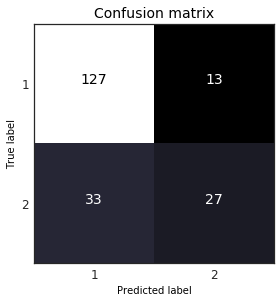

In [33]:
print "Classification Report:", classification_report(label_test, y_test_preds)
print 'Accuracy: {0:.3f}'.format(accuracy_score(label_test, y_test_preds))  
cnf_matrix = confusion_matrix(label_test, y_test_preds)
plot_confusion_matrix(cnf_matrix, classes=grid_search.best_estimator_.classes_)

Using XGBoost we are able to outperform our grid-searched classifiers in sci-kit learn as expected. A hyperparameter optimized XGBoost Classifier produced an accuracy score of 0.77 on the test data, the highest of all tested classifiers.

# Conclusion

** Model Results on Test Data**
- Logistic Regression: **0.73**
- Random Forest: **0.68**
- Support Vector Machines: **0.72**
- XGBoost: **0.77**

**Potential to improve**
- Testing out a Neural Network with Keras or TensorFlow
- More feature engineering with our given features, i.e. creating a column with a rank for Purpose, or creating new features from combining existing features such as Purpose and Duration in creative ways.
- Test on other similar data to see how well the model holds up as this data is limited to the the German market.
- Use Patsy and peel away the PCA/Scaling steps from a pipeline and pull coefficients from the gridsearch to find out how the coefficient weighting differs for each feature.

Using gradient boosted trees in XGBoost's classifier we were able to go as high as **0.77** on classification accuracy on the test data, decreasing false positives and negatives relative to the other models. As the size of the data is quite small, these classification algorithms tend to perform similarly however it would be interesting to see how well a neural network compares in results but it tends to be more computationally intensive and given the size of the data, tuning parameters and more feature engineering is likely to produce similar results.